In [ ]:
# automatic reload module
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/2024-11-24-AI-Hardware

/p/mmcardiac/Jerry/code/2024-11-24-AI-Hardware


In [2]:
# load labels from .csv file
training_label_fname = 'data/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
testing_label_fname = 'data/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'
# load training and testing label, which has no header row
# the first column is the image name, the second column is the label
import pandas as pd
training_datainfo = pd.read_csv(training_label_fname, header=None)
testing_datainfo = pd.read_csv(testing_label_fname, header=None)

# assign headers
training_datainfo.columns = ['image', 'label']
testing_datainfo.columns = ['image', 'label']

# convert training label from 'benign' / 'malignant' to 0 / 1
training_datainfo['label'] = training_datainfo['label'].apply(lambda x: 0.0 if x == 'benign' else 1.0)


In [3]:
training_datainfo.head()

,image,label
0,ISIC_0000000,0.0
1,ISIC_0000001,0.0
2,ISIC_0000002,1.0
3,ISIC_0000004,1.0
4,ISIC_0000006,0.0


In [4]:
testing_datainfo.head()

,image,label
0,ISIC_0000003,0.0
1,ISIC_0000012,0.0
2,ISIC_0000013,1.0
3,ISIC_0000014,0.0
4,ISIC_0000015,0.0


In [5]:
a, b = testing_datainfo.iloc[10]

In [6]:
testing_datainfo.iloc[10]

image    ISIC_0000037
label             0.0
Name: 10, dtype: object

In [7]:
b

0.0

In [8]:
len(testing_datainfo)

379

In [9]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io
from PIL import Image
from pathlib import Path
# from Collections import Union

# Define a transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images to 128x128
    transforms.ToTensor()           # Convert the images to PyTorch tensors
])

class CustomDataset(Dataset):
    def __init__(self, root_dir, datainfo, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.datainfo = datainfo

    def __len__(self):
        return len(self.datainfo)

    def __getitem__(self, idx):
        image_fname, label = self.datainfo.iloc[idx]
        # image = io.imread(Path(self.root_dir) / (image_fname+'.jpg'))
        image = Image.open(Path(self.root_dir) / (image_fname+'.jpg'))

        if self.transform:
            image = self.transform(image)

        return image, label

# Path to the dataset
training_dataset_path = '/p/mmcardiac/Jerry/code/2024-11-24-AI-Hardware/data/ISBI2016_ISIC_Part3_Training_Data'
test_dataset_path = '/p/mmcardiac/Jerry/code/2024-11-24-AI-Hardware/data/ISBI2016_ISIC_Part3_Test_Data'

# Create datasets from the datainfo
training_dataset = CustomDataset(root_dir=training_dataset_path, datainfo=training_datainfo, transform=transform)
test_dataset = CustomDataset(root_dir=test_dataset_path, datainfo=testing_datainfo, transform=transform)

# Create DataLoaders to load the images in batches
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

# Example: Iterate through the DataLoader and print the shape of the images and labels
for images, labels in test_dataloader:
    print(images.shape, labels.shape)
    break  # Just to show the output for one batch

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [19]:
# check the label distribution
print(training_datainfo['label'].value_counts())
print(testing_datainfo['label'].value_counts())

label
0.0    727
1.0    173
Name: count, dtype: int64
label
0.0    304
1.0     75
Name: count, dtype: int64


In [10]:
training_datainfo.iloc[10]

image    ISIC_0000016
label             0.0
Name: 10, dtype: object

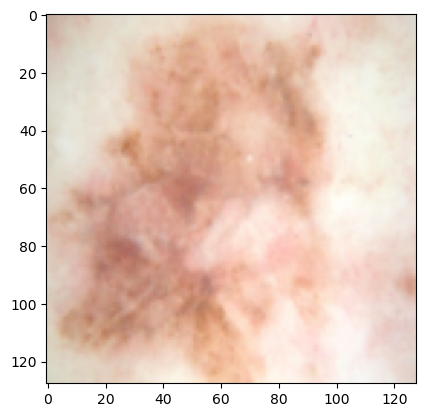

In [11]:
import matplotlib.pyplot as plt
plt.imshow(images[0].permute(1, 2, 0))

In [12]:
# check the shape of random 10 images in the dataset
import random
for idx in random.sample(range(len(test_dataset)), 10):
    image, label = test_dataset[idx]
    print(image.shape, label)

torch.Size([3, 128, 128]) 0.0
torch.Size([3, 128, 128]) 0.0
torch.Size([3, 128, 128]) 0.0


torch.Size([3, 128, 128]) 0.0
torch.Size([3, 128, 128]) 0.0
torch.Size([3, 128, 128]) 0.0
torch.Size([3, 128, 128]) 0.0
torch.Size([3, 128, 128]) 0.0
torch.Size([3, 128, 128]) 0.0
torch.Size([3, 128, 128]) 0.0


In [13]:
# use GPU 3 if available
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from torchvision import models
from torch import nn
model = models.resnet18(pretrained=True)
#model.fc = nn.Linear(model.fc.in_features, 1)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)
model = model.to(device)

/u/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/u/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(32 * 32 * 32, 128)
#         self.fc2 = nn.Linear(128, 1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = x.view(-1, 32 * 32 * 32)
#         x = self.relu(self.fc1(x))
#         x = self.sigmoid(self.fc2(x))
#         return x

# Initialize the model, loss function, and optimizer
# model = SimpleCNN().to(device)
# use pre-trained ResNet-18 model


criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([4.0]))
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing loop
num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in training_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(training_dataloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_dataloader)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')



Epoch 1/10, Train Loss: 0.5100, Train Accuracy: 0.8000, Test Loss: 0.6794, Test Accuracy: 0.8021


KeyboardInterrupt: 

In [ ]:
# check the predictions on all test data
model.eval()
predictions = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        predictions.extend(predicted.cpu().numpy().flatten().tolist())

In [ ]:
# check the accuracy on the test data
test_labels = testing_datainfo['label'].values
test_predictions = predictions
test_accuracy = (test_labels == test_predictions).mean()
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.7757


In [ ]:
print(sum(test_labels) / len(test_labels))

0.19788918205804748


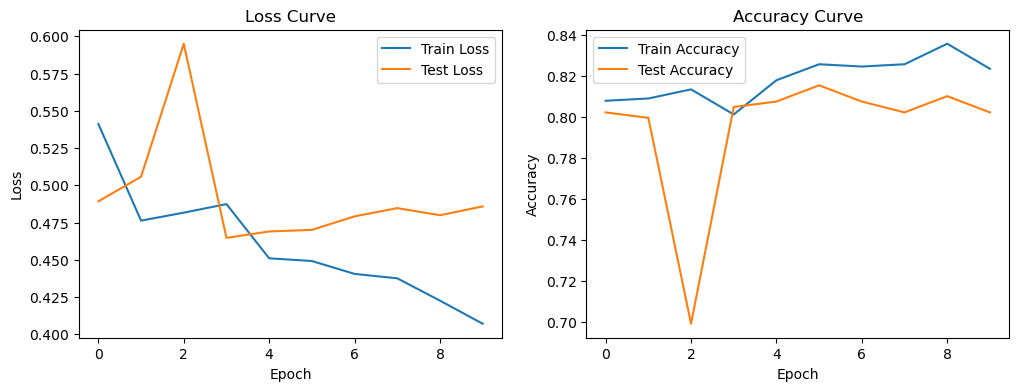

In [ ]:
# Plot the training and testing loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

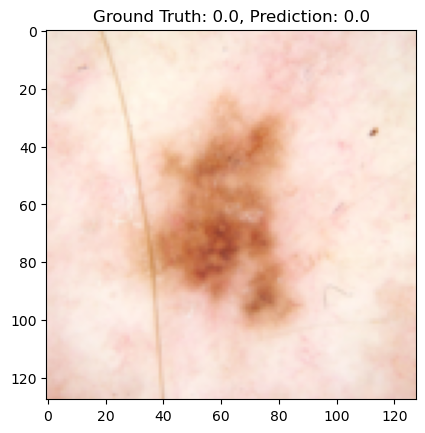

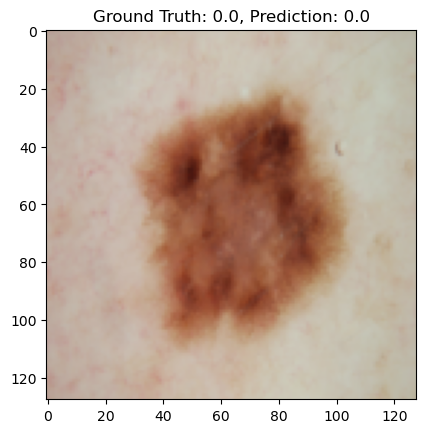

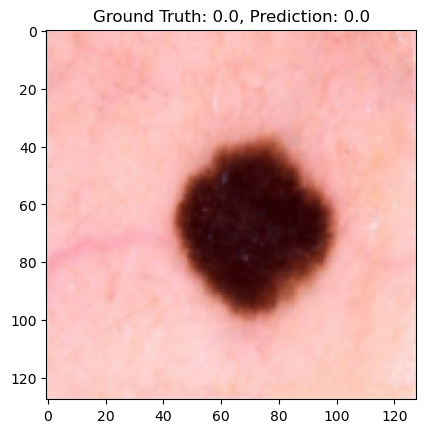

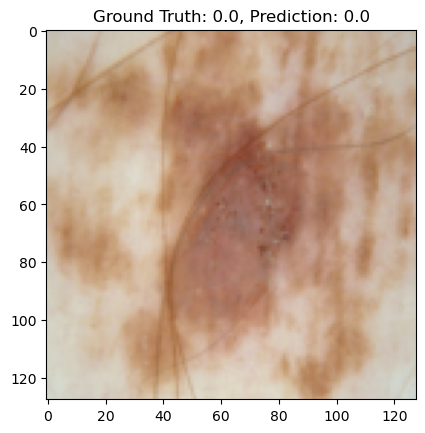

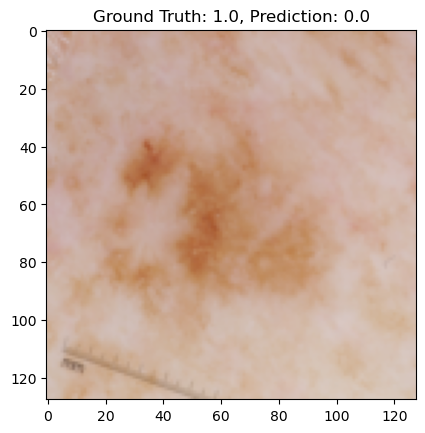

In [ ]:
import random

# Set the model to evaluation mode
model.eval()

# Randomly select 5 images from the test dataset
random_indices = random.sample(range(len(test_dataset)), 5)

for idx in random_indices:
    image, true_label = test_dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = torch.tensor([true_label]).to(device).float().unsqueeze(1)

    with torch.no_grad():
        output = model(image)
        predicted_label = (output > 0.5).float()

    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.title(f'Ground Truth: {true_label.item()}, Prediction: {predicted_label.item()}')
    plt.show()